In [2]:
import pandas as pd
import seaborn as sns
import numpy as np 
import math
import tensorflow as tf
from numpy.ma.core import ceil
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, colors
from sklearn import preprocessing as sk_preprocessing
from sklearn.preprocessing import StandardScaler #normalization
from sklearn.preprocessing import MinMaxScaler #normalization
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import os
import warnings # supress warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support


In [4]:
data = pd.read_csv('Kidney_data.csv')
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [5]:
data.drop('id', axis = 1, inplace = True) #drop ID column

#Replace incorrect values
data['dm'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)

data['cad'] = data['cad'].replace(to_replace = '\tno', value='no')

data['classification'] = data['classification'].replace(to_replace = {'ckd\t': 'ckd'})


In [7]:
# Convert some columns to numeric values before seperating data into training and testing
data['pcv'] = pd.to_numeric(data['pcv'], errors='coerce')
data['wc'] = pd.to_numeric(data['wc'], errors='coerce')
data['rc'] = pd.to_numeric(data['rc'], errors='coerce')

data['classification'] = data['classification'].map({'ckd': 0, 'notckd': 1})
data['classification'] = pd.to_numeric(data['classification'], errors='coerce')

In [8]:
# Extracting categorical and numerical columns

# select categorical columns
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
print('categorical_cols are : \n\n',categorical_cols , '\n')
print('-.'*40 , '\n')

# select numeric columns
df_numeric = data.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('numeric_cols  are  : \n\n' , numeric_cols)


categorical_cols are : 

 ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'] 

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-. 

numeric_cols  are  : 

 ['age' 'bp' 'sg' 'al' 'su' 'bgr' 'bu' 'sc' 'sod' 'pot' 'hemo' 'pcv' 'wc'
 'rc' 'classification']


In [11]:
data.isnull().sum() # sum of the null values

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [12]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 25 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
rbc,152,38.0
rc,131,32.8
wc,106,26.5
pot,88,22.0
sod,87,21.8
pcv,71,17.8
pc,65,16.2
hemo,52,13.0
su,49,12.2
sg,47,11.8


In [16]:
new_data=data.copy()
for col in new_data.columns:
    if(data[col].dtype=='object'):
        new_data[col]=data[col].fillna(method='bfill')
    else:
        new_data[col]=data[col].fillna(new_data[col].mean()) 


In [17]:
# select numeric columns
df_numeric = new_data.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('numeric_cols  are  : \n\n' , numeric_cols)

numeric_cols  are  : 

 ['age' 'bp' 'sg' 'al' 'su' 'bgr' 'bu' 'sc' 'sod' 'pot' 'hemo' 'pcv' 'wc'
 'rc' 'classification']


In [18]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in new_data:
    if new_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(new_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(new_data[col])
            # Transform both training and testing data
            new_data[col] = le.transform(new_data[col])
            # app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

#LabelEncoder can be used to normalize labels or transform non-numerical labels 

10 columns were label encoded.


In [19]:
# one-hot encoding of categorical variables
new_data = pd.get_dummies(new_data)
# app_test = pd.get_dummies(app_test)

print('Data Features shape: ', new_data.shape)
# print('Testing Features shape: ', app_test.shape)

Data Features shape:  (400, 25)


In [20]:
new_data #the clean data to use

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,0,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,0,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,0,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,0,0,0,0,0,1


In [21]:
new_data.to_csv('cleandata.csv') #make the data into a new dataset that is clean

In [22]:
X = new_data.iloc[:,:-1].values
Y = new_data.iloc[:,-1].values
print(X.shape, Y.shape)

(400, 24) (400,)


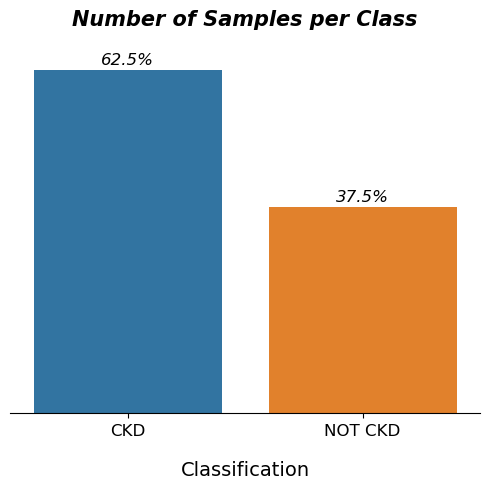

In [24]:
plt.figure(figsize=(5, 5))

sns.countplot(data = data , x = 'classification' , order = data['classification'].value_counts().index)
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1], labels=['CKD', 'NOT CKD'], fontsize=12)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Classes' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/data.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())), ha='center', 
                va='bottom', color='black', xytext=(0,2), rotation='horizontal', textcoords='offset points', fontsize = 12, fontstyle = 'italic')

# plt.savefig("samples.png")
plt.tight_layout()

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new_features = scaler.fit_transform(X)
print(new_features)

[[0.52272727 0.23076923 0.75       ... 0.         0.         0.        ]
 [0.05681818 0.         0.75       ... 0.         0.         0.        ]
 [0.68181818 0.23076923 0.25       ... 1.         0.         1.        ]
 ...
 [0.11363636 0.23076923 0.75       ... 0.         0.         0.        ]
 [0.17045455 0.07692308 1.         ... 0.         0.         0.        ]
 [0.63636364 0.23076923 1.         ... 0.         0.         0.        ]]


In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(new_features, Y, test_size = 0.3, random_state = 42, stratify=Y)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes


(280, 24) (280,) (120, 24) (120,)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        75
           1       0.98      1.00      0.99        45

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

----------------- Overall Results -----------------
Accuracy Result: 99.17%
Precision Result: 98.91%
Recall Result: 99.33%
F1-Score Result: 99.11%


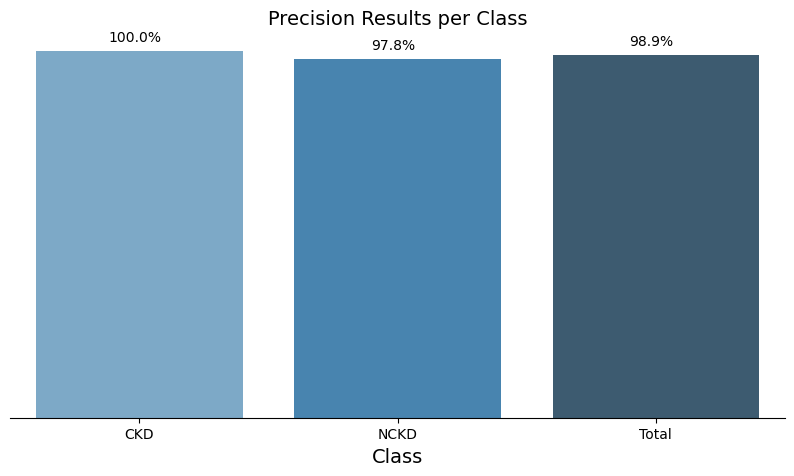

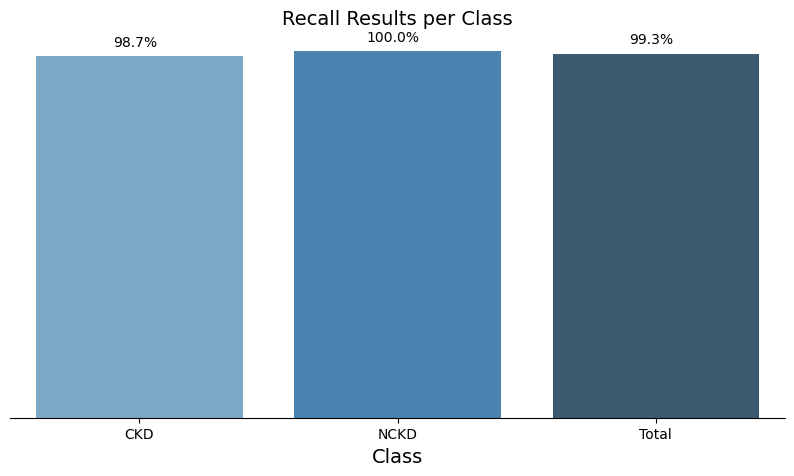

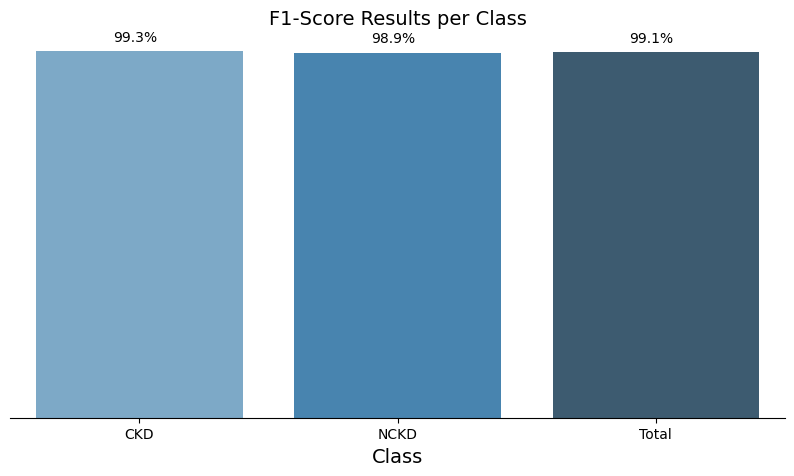

In [30]:
# model fit
knn = SVC(gamma=0.1, C=1000)
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

In [33]:
from keras.models import Sequential
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(24,1)))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Train the model
model.fit(new_features, Y, epochs=10, batch_size=32)

Epoch 1/10
13/13 [==============================] - 1s 6ms/step - loss: 0.6145 - accuracy: 0.6350
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 0.4319 - accuracy: 0.9300
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 0.2368 - accuracy: 0.9725
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.1343 - accuracy: 0.9600
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0867 - accuracy: 0.9725
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.9750
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 0.0475 - accuracy: 0.9850
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9925
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.9725
Epoch 10/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0368 - accuracy: 0.9900


In [36]:
# Use the trained model to make predictions on the test set
y_pred = model.predict(x_test).argmax(axis=1)

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy)

4/4 [==============================] - 0s 9ms/step
Test accuracy: 0.9833333333333333


In [37]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[73  2]
 [ 0 45]]
